In [ ]:
!unzip Test.zip -d data >> /dev/null # 解压压缩包
!rm -rf Test.zip # 删除压缩包

In [ ]:
!rm -rf Test Captions_.xlsx

In [1]:
import scipy.io
from PIL import Image
# 加载 .mat 文件
mat_file_path = '/home/featurize/work/Dataset2/data/Testing/Labels/359971.mat'
data = scipy.io.loadmat(mat_file_path)
jpg_file_path = '/home/featurize/work/Dataset2/data/Testing/Images/359971.jpeg'
# 查看 .mat 文件的内容
print(data)


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed Jun 12 13:30:53 2024', '__version__': '1.0', '__globals__': [], 'Four_points': array([[167.57813411,  92.01078717],
       [480.94956268, 104.80145773],
       [181.96763848, 103.73556851],
       [451.63760933, 111.196793  ],
       [ 23.88757369,  23.74446162]]), 'Angles': array([[36.83635211, 14.64532168]])}


In [7]:
four_points = data['Four_points']
angles = data['Angles']

print("Four_points:")
print(four_points)

print("Angles:")
print(angles)

Four_points:
[[167.57813411  92.01078717]
 [480.94956268 104.80145773]
 [181.96763848 103.73556851]
 [451.63760933 111.196793  ]
 [ 23.88757369  23.74446162]]
Angles:
[[36.83635211 14.64532168]]


In [8]:
left_head = four_points[2]
right_head = four_points[3]
center1 = four_points[0]
center2 = four_points[1]
radius1 = four_points[4][0]
radius2 = four_points[4][1]

In [23]:
def calculate_angle(center, head, opposite_center):
    """
    Calculate the angle formed by the three points: center1, head, and opposite_center.
    
    Parameters:
    - center1: The first center point.
    - head: The head point.
    - opposite_center: The opposite center point.
    
    Returns:
    - angle in degrees.
    """
    center = np.array(center)
    head = np.array(head)
    opposite_center = np.array(opposite_center)
    
    # Vector from center1 to head
    vector1 = head - center
    # Vector from center1 to opposite_center
    vector2 = opposite_center - center
    
    # Calculate the cosine of the angle using dot product and norms
    cos_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    
    # Clamp the cosine value to the range [-1, 1] to avoid numerical issues
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    
    # Calculate the angle in radians and then convert to degrees
    angle = np.arccos(cos_angle)
    return np.degrees(angle)
calculate_angle(center1, left_head, center2)
calculate_angle(center2, right_head, center1)

14.645321676551822

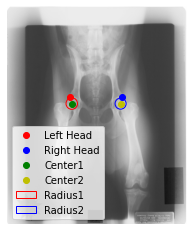

In [4]:
import matplotlib.pyplot as plt
import numpy as np

image = Image.open(jpg_file_path)
image_array = np.array(image)

# 在图像上绘制点和圆
plt.imshow(image_array)
plt.scatter(left_head[0], left_head[1], c='r', label='Left Head')  # 绘制左头点，使用红色（'r'）表示
plt.scatter(right_head[0], right_head[1], c='b', label='Right Head')  # 绘制右头点，使用蓝色（'b'）表示
plt.scatter(center1[0], center1[1], c='g', label='Center1')  # 绘制中心点1，使用绿色（'g'）表示
plt.scatter(center2[0], center2[1], c='y', label='Center2')  # 绘制中心点2，使用黄色（'y'）表示

# 绘制半径为radius1和radius2的圆
circle1 = plt.Circle((center1[0], center1[1]), radius1, color='r', fill=False, label='Radius1')
circle2 = plt.Circle((center2[0], center2[1]), radius2, color='b', fill=False, label='Radius2')
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)

plt.axis('off')  # 隐藏坐标轴
plt.legend()  # 显示图例
plt.show()

In [2]:
import json
import os
from PIL import Image
import scipy.io

coco = {}

In [3]:
#class_list= {
#    'supercategory': 'sjb_rect',
#    'id': 1,
#    'name': 'sjb_rect',
#    'keypoints': ['left_top', 'right_top', 'left_bottom', 'right_bottom'], # 大小写敏感
#    'skeleton':[[0,2], [1,3], [2,3]]
#}
class_list= {
    'supercategory': 'sjb_rect',
    'id': 1,
    'name': 'sjb_rect',
    'keypoints': ['head'], # 大小写敏感
    'skeleton':[]
}

In [4]:
coco['categories'] = []
coco['categories'].append(class_list)

coco['images'] = []
coco['annotations'] = []

IMG_ID = 0
ANN_ID = 0

In [5]:
import json
import os
import scipy.io
import numpy as np
from PIL import Image



def process_single_image(mat_data, image_id, four_points, radii):
    global ANN_ID
    coco_annotations = []

    # 获取第一个注释的关键点和边界框
    left_head = four_points[2]
    #center1 = four_points[0]
    radius1 = radii[0]
    min_x1 = left_head[0] - radius1
    max_x1 = left_head[0] + radius1
    min_y1 = left_head[1] - radius1
    max_y1 = left_head[1] + radius1
    bbox_w1 = max_x1 - min_x1
    bbox_h1 = max_y1 - min_y1

    bbox_dict1 = {
        'category_id': 1,
        'iscrowd': 0,
        'image_id': image_id,
        'id': ANN_ID,
        'bbox': [min_x1, min_y1, bbox_w1, bbox_h1],
        'area': bbox_w1 * bbox_h1,
        'segmentation': [],
        'keypoints': [left_head[0], left_head[1], 2],
        'num_keypoints': 1
    }
    ANN_ID += 1

    # 获取第二个注释的关键点和边界框
    right_head = four_points[3]
    #center2 = four_points[1]
    radius2 = radii[1]
    min_x2 = right_head[0] - radius2
    max_x2 = right_head[0] + radius2
    min_y2 = right_head[1] - radius2
    max_y2 = right_head[1] + radius2
    bbox_w2 = max_x2 - min_x2
    bbox_h2 = max_y2 - min_y2

    bbox_dict2 = {
        'category_id': 1,
        'iscrowd': 0,
        'image_id': image_id,
        'id': ANN_ID,
        'bbox': [min_x2, min_y2, bbox_w2, bbox_h2],
        'area': bbox_w2 * bbox_h2,
        'segmentation': [],
        'keypoints': [right_head[0], right_head[1], 2],
        'num_keypoints': 1
    }
    ANN_ID += 1

    coco_annotations.append(bbox_dict1)
    coco_annotations.append(bbox_dict2)
    
    return coco_annotations



In [13]:
annotations =process_single_image(data,1,four_points[:4],four_points[4:][0])

In [14]:
annotations

[{'category_id': 1,
  'iscrowd': 0,
  'image_id': 1,
  'id': 0,
  'bbox': [564.5486822965353,
   846.3482240233376,
   113.86487957075019,
   113.86487957075019],
  'area': 12965.210799661443,
  'segmentation': [],
  'keypoints': [621.4811220819104, 903.2806638087127, 2],
  'num_keypoints': 1},
 {'category_id': 1,
  'iscrowd': 0,
  'image_id': 1,
  'id': 1,
  'bbox': [1087.4000986027672,
   847.3982165580746,
   109.72261887007653,
   109.72261887007676],
  'area': 12039.0530917081,
  'segmentation': [],
  'keypoints': [1142.2614080378055, 902.259525993113, 2],
  'num_keypoints': 1}]

In [6]:
IMG_ID = 0
ANN_ID = 0

In [7]:
def create_coco_dataset(image_dir, mat_dir, output_file):
    global IMG_ID
    global coco
    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    mat_files = sorted([f for f in os.listdir(mat_dir) if f.endswith('.mat')])
    
    print(f"Total number of images in {image_dir}: {len(image_files)}")
    
    for image_file, mat_file in zip(image_files, mat_files):
            # 加载图片
            image_path = os.path.join(image_dir, image_file)
            image = Image.open(image_path)
            width, height = image.size

            # 加载 .mat 文件
            mat_file_path = os.path.join(mat_dir, mat_file)
            data = scipy.io.loadmat(mat_file_path)
            four_points = data['Four_points'][:4]
            radii = data['Four_points'][4:][0]

            # 添加图像信息
            coco["images"].append({
                "id": IMG_ID,
                "file_name": image_file,
                "width": width,
                "height": height
            })

            # 处理单个图像的注释
            annotations = process_single_image(data, IMG_ID, four_points, radii)
            coco["annotations"].extend(annotations)

            IMG_ID += 1
        
        
    print(f"Total number of processed images: {len(coco['images'])}")
    
    # 保存为 COCO 格式的 JSON 文件
    with open(output_file, 'w') as f:
        json.dump(coco, f, indent=4)
        
    return coco

# 使用示例
#image_dir = 'data/Test/Images'
#mat_dir = 'data/Test/Labels'
#output_file = 'data/Test/cocoLabels_head.json'

#coco_data = create_coco_dataset(image_dir, mat_dir, output_file)

In [8]:
from matplotlib import patches
def plot_coco_annotations(coco, image_dir):
    for image_info in coco["images"]:
        image_id = image_info["id"]
        image_file = image_info["file_name"]
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path)
        
        fig, ax = plt.subplots(figsize=(10, 10))  # 增大图片显示尺寸
        ax.imshow(image)
        ax.set_aspect('equal', 'box')

        # 画出每个注释
        for annotation in coco["annotations"]:
            if annotation["image_id"] == image_id:
                bbox = annotation['bbox']
                keypoints = annotation['keypoints']
                
                # 根据bbox计算半径
                radius = bbox[2] / 2  # bbox的宽度的一半作为半径
                
                # 画圆
                head_x, head_y = keypoints[0], keypoints[1]
                #center_x, center_y = keypoints[0], keypoints[1]
                #circle = plt.Circle((head_x, head_y), radius, color='b', fill=False)
                #ax.add_patch(circle)
                
                # 画边界框
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(rect)
                
                # 画关键点
                #plt.plot(center_x, center_y, 'ro', markersize=5)  # 'ro'表示红色点，markersize调整关键点的大小
                plt.plot(head_x, head_y, 'bo', markersize=5)
        
        plt.title(f'Image ID: {image_id}')
        plt.show()


In [ ]:
image_dir = '/home/featurize/work/Dataset2/data/Training/Images'
mat_dir = '/home/featurize/work/Dataset2/data/Training/Labels'
output_file = '/home/featurize/work/Dataset2/data/Training/cocoLabels_head.json'

coco_data = create_coco_dataset(image_dir, mat_dir, output_file)
plot_coco_annotations(coco_data, image_dir)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
image_dir = '/home/featurize/work/Dataset2/data/Validation/Images'
mat_dir = '/home/featurize/work/Dataset2/data/Validation/Labels'
output_file = '/home/featurize/work/Dataset2/data/Validation/cocoLabels_head.json'

coco_data_valid = create_coco_dataset(image_dir, mat_dir, output_file)
plot_coco_annotations(coco_data_valid, image_dir)